<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/0_Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Neural Network with PyTorch. Original source can be found [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [4]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


In [5]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in: int, H: int, D_out: int):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
          D_in (int): input dimenstion
          H (int): hidden dimension
          D_out (int): output dimension
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return F.log_softmax(y_pred)

In [34]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 30

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.QMNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.QMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True
)


In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
#print(batch_idx)
#print(example_data)
#print(example_targets)

torch.Size([1000, 1, 28, 28])


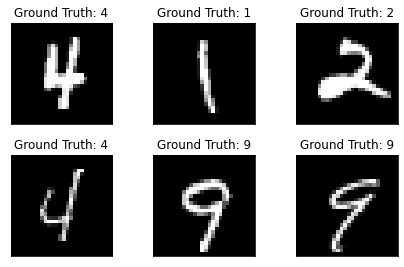

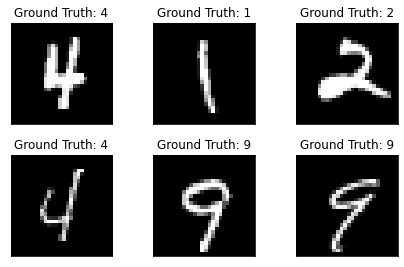

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size = 64
input_size = 784
hidden_size = 100
output_size = 10

# get data and labels from train_loader
x, y = next(iter(train_loader))

# Flatten tensor
print(x.shape)


torch.Size([64, 1, 28, 28])


In [26]:
def train(epoch: int, criterion: F, optimizer):
    """Forward pass: Compute predicted y by passing x to the model
      
    """ 
    for batch_idx, (x, y) in enumerate(train_loader):
      x = x.view(x.shape[0], -1)
      optimizer.zero_grad()
      y_pred = model(x)
      # Compute and print loss
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()

      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(x), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [42]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      x = x.view(x.shape[0], -1)
      y_hat = model(x)
      test_loss += F.nll_loss(y_hat, y, size_average=False).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [43]:
# Construct our model by instantiating the class defined above
model = TwoLayerNet(input_size, hidden_size, output_size)
criterion = F.nll_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.8424, Accuracy: 35756/60000 (60%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.876528
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.842281
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.869565
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.846914
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.818884
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.925762
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.830215
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.849445
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.852028
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.815538
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.756080
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.806300
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.884690
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.742288
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.756050
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.794214
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.803108
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.740352
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.770573
Train E

In [1]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
print(test_counter)
plt.scatter(test_counter, test_losses, color='red')


plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

NameError: ignored